<font color='blue'> **26_CE_Jacob(1939) - Elastic Aquifer Loading - A Train passing by** </font> 

In [10]:
import os ; import pathlib as pl ; import pandas as pd ; import numpy as np               ;  import matplotlib.pyplot as plt ; from pathlib import Path  
import datetime ; import flopy   ; from modflow_devtools.misc import get_env              ; write=get_env("WRITE", True);run=get_env("RUN", True) 
sim_ws  = out  = Path("./26")                          ; sim_ws.mkdir(exist_ok=True)      ; sim_name = "ex-gwf-csub-p01"
exe_name  = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe'    ; workspace = figs_path = sim_ws   ; from flopy.plot.styles import styles 
path  = 'E:\\15_REPOS\\00_BETAMI\\bin\\data_modflow6-examples\\ex-gwf-csub-p01'           ; import matplotlib as mpl
fpath = os.path.join(path,"train_load_193704231304.csv")                                  ; fpath2 = os.path.join(path,"s201_gw_2sec.csv")

In [11]:
length_units = "meters" ; nlay = 3 ;ncol = 35 ;nrow = 1   ;delrmax = 100 ;delc = 100.6 ;top = 0 ;strt = -10.7         # delr0 = 0.5
time_units = "seconds"  ; botm_str = "-12.2,-21.3,-30.5"  ;icelltype_str = "1,0,0"    ;k11_str = "1.8e-5 ,3.5e-10 ,3.1e-5"   ;sy_str = "0.1,0.05,0.25"   
sgm = 1.7 ; sgs = 2 ;cg_ske_str = "3.3e-5,6.6e-4,4.5e-7"  ;locw201 = 11               ;cg_theta_str = "0.25 ,0.50 ,  0.30"  
nper=2;nouter=500;ninner=300;hclose=0.000000001;rclose=0.000001;linaccel="bicgstab";relax=1   
delr = np.ones(ncol, dtype=float) * 0.5    ; xmax = delr[0]

for idx in range(1, ncol):     dx = min(delr[idx - 1] * 1.2, 100.0)   ;     xmax += dx       ; delr[idx] = dx
csv_load = np.genfromtxt(fpath, names=True, delimiter=",")            ; C_ts = []
for idx in range(csv_load.shape[0]):                                    C_ts.append((csv_load["sim_time"][idx], csv_load["load"][idx]))

tdis_ds   = ((0.5, 1, 1.0),(csv_load["sim_time"][-1] - 0.5, csv_load["sim_time"].shape[0] - 2, 1),)
dstart    = datetime.datetime(1937, 4, 23, 13, 5, 55)             ; date_list = [dstart + datetime.timedelta(seconds=x) for x in csv_load["sim_time"]]
botm      = [float(value) for value in    botm_str.split(",")]    ; k11       = [float(value) for value in      k11_str.split(",")]
icelltype = [int(value) for value in icelltype_str.split(",")]    ; sy        = [float(value) for value in       sy_str.split(",")]
cg_ske    = [float(value) for value in  cg_ske_str.split(",")]    ; cg_theta  = [float(value) for value in  cg_theta_str.split(",")]

In [ ]:
th=pd.DataFrame(csv_load)  ; th.to_csv (sim_ws / '01_train_load.csv')      ; th=pd.DataFrame(C_ts)       ; th.to_csv (sim_ws / '02_train_load_2.csv')  
th=pd.DataFrame(date_list) ; th.to_csv (sim_ws/  '03_date_list.csv' )      ; th=pd.DataFrame(delr)       ; th.to_csv (sim_ws/  '04_delr.csv'      )
date_listA = [datetime.timedelta(seconds=x) for x in csv_load["sim_time"]] ; th=pd.DataFrame(date_listA) ; th.to_csv (sim_ws/  '03a_date_listA.csv' ) 

In [13]:
def build_models():
    obs_recarray={"gwf_calib_obs.csv":[("w3_1_1" ,"HEAD" ,(2 ,0 ,locw201))]}    ; C_ID = f"{sim_name}.load.ts"  # loc_11
    head_filerecord = f"{sim_name}.hds"   ; budget_filerecord=f"{sim_name}.cbc"

    sim = flopy.mf6.MFSimulation (sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis (sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms  (sim ,outer_maximum=nouter ,outer_dvclose=hclose ,linear_acceleration=linaccel ,inner_maximum=ninner ,
                           inner_dvclose=hclose ,relaxation_factor=relax ,rcloserecord=f"{rclose}strict")
    gwf=flopy.mf6.ModflowGwf (sim ,modelname=sim_name ,save_flows=True ,newtonoptions="newton")
    flopy.mf6.ModflowGwfdis  (gwf ,length_units=length_units ,nlay=nlay ,nrow=nrow ,ncol=ncol ,delr=delr ,delc=delc ,top=top ,botm=botm)
    flopy.mf6.ModflowUtlobs  (gwf ,digits=10 ,print_input=True ,continuous = obs_recarray)
    flopy.mf6.ModflowGwfwel  (gwf, stress_period_data= [2,0,11,-0.0000000000000000000001])
    flopy.mf6.ModflowGwfic   (gwf ,strt=strt)
    flopy.mf6.ModflowGwfnpf  (gwf ,icelltype=icelltype ,k=k11 ,save_specific_discharge=True)
    flopy.mf6.ModflowGwfsto  (gwf ,iconvert=icelltype ,ss=0.0 ,sy=sy ,steady_state={0:True} ,transient={1:True})
    csub=flopy.mf6.ModflowGwfcsub (gwf ,print_input=True ,update_material_properties=True ,save_flows=True ,ninterbeds=0 ,maxsig0=1 ,
                                   compression_indices=None ,sgm=sgm ,sgs=sgs ,cg_theta=cg_theta ,cg_ske_cr=cg_ske ,beta=4.65120000e-10 ,
                                   packagedata=None ,stress_period_data={0:[[(0 ,0 ,0) ,"LOAD"]]})
    csub.ts.initialize(filename=C_ID ,timeseries=C_ts, time_series_namerecord=["LOAD"] ,interpolation_methodrecord=["linear"],sfacrecord=["1.05"])
    flopy.mf6.ModflowGwfoc    (gwf ,head_filerecord=head_filerecord ,budget_filerecord=budget_filerecord ,
                               saverecord=[("HEAD" ,"LAST") ,("BUDGET" ,"LAST")] ,printrecord=[("BUDGET" ,"LAST")])
    return sim
def write_models(sim, silent=True):     sim.write_simulation(silent=silent)
def run_models(sim, silent=True):       success, buff = sim.run_simulation(silent=silent, report=True)  ; assert success, buff
def scenario(silent=True):
    sim = build_models()
    if write:      write_models(sim, silent=silent)
    if run:        run_models(sim, silent=silent)
scenario(silent=True)

In [14]:
sim = build_models()        ; gwf = sim.get_model(sim_name)      ; xx, yy = (gwf.modelgrid.xcellcenters[0, locw201],gwf.modelgrid.ycellcenters[0, 0]) 
gwf.oc.output.methods()     ; hobj=gwf.output.head()             ; head=hobj.get_data() ; times = hobj.get_times()  
from flopy.utils.postprocessing import get_water_table           ; what=get_water_table(head)    ; print(times)  

[0.5, 59.0]


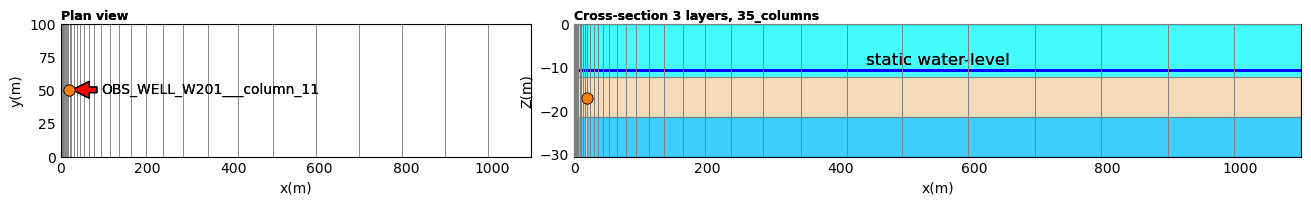

In [15]:
def beta_plot(ax):
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax1, extent=(0, xmax, 0, 100))    ; mm.plot_grid(color="0.5", lw=0.5) ; ax1.set_ylabel("y(m)")
    ax1.plot(xx, yy, marker="o", ms=8, zorder=100, mew=0.5, mec="black")          ; styles.heading(ax1, heading="Plan view")
    ax1.annotate("OBS_WELL_W201___column_11" ,xy=(xx+5,yy) ,xytext=(xx+75,yy) ,ha="left" ,va="center",arrowprops=dict(facecolor="red",shrink=0.05))
    
    mc = flopy.plot.PlotCrossSection(model = gwf, line={"Row": 0},ax=ax2,extent=(0, xmax, botm[-1], 0))  ;  mc.plot_grid(color="0.5", lw=0.5, zorder=100)
    ax2.fill_between([0, delr.sum()], y1=top    , y2=botm[0], color="#08FCFC" , alpha=0.5)
    ax2.fill_between([0, delr.sum()], y1=botm[0], y2=botm[1], color="#F1D0A5" , alpha=0.5)
    ax2.fill_between([0, delr.sum()], y1=botm[1], y2=botm[2], color="#00BFFF" , alpha=0.5)  ;  mc.plot_grid(color="0.5", lw=0.5, zorder=100)     
    mc.plot_surface(what, masked_values=[1e30], color="blue", lw=2) ; ax2.text(delr.sum()/2, -10, "static water-level", va="bottom", ha="center", size=12)
    ax2.set_ylabel("Z(m)") ; ax.set_xlabel("x(m)") ; styles.heading(ax2, heading="Cross-section 3 layers, 35_columns") ; styles.remove_edge_ticks(ax)
    ax2.plot(20, -17, marker="o", ms=8, zorder=100, mew=0.5, mec="black")    ; mc.plot_bc("WEL", color="pink")
plt.figure(figsize=(16,10))
ax1 = plt.subplot2grid((5, 5), (0, 0), colspan=2, rowspan=1)  ;ax2 = plt.subplot2grid((5,5),(0,2),colspan=3,rowspan=1) ;beta_plot(ax1);beta_plot(ax2)

In [16]:
sim_obs=gwf.obs.output.obs().data;h0=sim_obs["W3_1_1"][0];sim_obs["W3_1_1"]-=h0  ;sim_date=[dstart+datetime.timedelta(seconds=x) for x in sim_obs["totim"]]

dtype = [("date", object), ("dz_m", float)]   ; obs_head = np.genfromtxt(fpath2, names=True, delimiter=",", dtype=dtype)   ; obs_date = []
for sa in obs_head["date"]:                     obs_date.append(datetime.datetime.strptime(sa.decode("utf-8"), "%m-%d-%Y %H:%M:%S.%f"))
t0, t1 = obs_date[0], obs_date[-1] 

th=pd.DataFrame(sim_obs) ; th.to_csv (sim_ws/'05_sim_obs.csv')   ; th=pd.DataFrame(obs_date)                     ; th.to_csv (sim_ws/'06_obs_date.csv') 
s201_gw_2sec_L= np.loadtxt(fpath2, dtype=str, usecols = False)   ; np.savetxt(sim_ws / "07_s201_gw_2sec.csv", s201_gw_2sec_L, fmt ="%s", delimiter=",")
th=pd.DataFrame(obs_head)                                                                                        ; th.to_csv (sim_ws/'08_obs_head.csv')

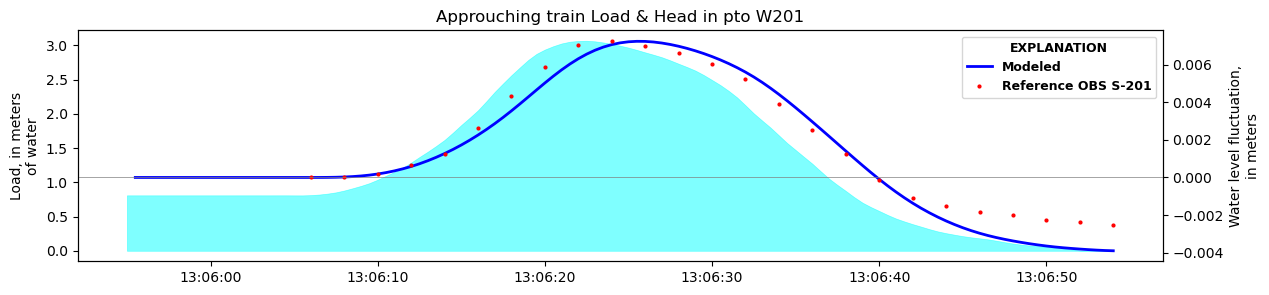

In [17]:
fig = plt.figure(figsize=(14, 3))             ; ax = fig.add_subplot(111)                                 ; ax.set_ylabel("Load, in meters\nof water")
ax.fill_between (date_list  ,csv_load["load"] , y2=0, color="cyan", lw=0.5, alpha=0.5)     ; ax.set_title('Approuching train Load & Head in pto W201') 

ax2 = ax.twinx()  ;  ax2.plot(sim_date, sim_obs["W3_1_1"], color="blue", lw=2, label="Modeled")
ax2.plot           (obs_date ,obs_head["dz_m"],color="red",lw=0,ms=4,marker=".",label="Reference OBS S-201")     ; ax2.axhline(0, lw=0.5, color="0.5")
ax2.set_ylabel     ("Water level fluctuation,\nin meters")                      ; leg=styles.graph_legend(ax2,loc="upper right",ncol=1)   ; plt.show()